In [227]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
# train_X = np.random.uniform(-1, 1, (10, 15))

In [229]:
# from functions.functions import *

# f = Ackley(dims=15)

In [230]:
# train_Y = np.array([f(x) for x in train_X])
# train_Y.shape

In [231]:
# train_Y

In [234]:
# test_X = torch.randn(5, 15)
# test_X.shape

In [232]:
# train_X = torch.from_numpy(train_X)
# train_Y = torch.from_numpy(train_Y)
# train_Y = train_Y + torch.randn(train_Y.size()) * math.sqrt(0.04)
# train_X.shape, train_Y.shape

In [269]:
# Training data is 100 points in [0,1] inclusive regularly spaced
# train_X = torch.linspace(0, 1, 100)
train_X = torch.rand(5)
# True function is sin(2*pi*x) with Gaussian noise
train_Y = torch.sin(train_X * (2 * math.pi)) + torch.randn(train_X.size()) * math.sqrt(0.04)

train_X = train_X.unsqueeze(-1)
train_X.shape, train_Y.shape

(torch.Size([5, 1]), torch.Size([5]))

In [270]:
test_X = torch.linspace(0, 1, 20).unsqueeze(-1)

In [271]:
# train_Yvar = torch.full_like(train_Y, 0.1**2)

In [272]:
# observed_noise_model = SingleTaskGP(
#     train_X, train_Y, train_Yvar
# )

In [273]:
# predict = observed_noise_model.forward(test_X)

In [274]:
# predict.mean

In [275]:
# predict.variance

In [276]:
from gpytorch.kernels import MaternKernel

In [277]:
kernel = MaternKernel(nu=2.5)

In [278]:
# model = SingleTaskGP(
#     train_X, train_Y, train_Yvar, covar_module=kernel
# )

In [279]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.MaternKernel(nu=2.5)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_X, train_Y, likelihood)

In [280]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [281]:
model

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
)

In [282]:
for item, value in likelihood.state_dict().items():
    print(item, value)

noise_covar.raw_noise tensor([0.])
noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04)
noise_covar.raw_noise_constraint.upper_bound tensor(inf)


In [283]:
# why does likelihood have parameters to train? 

In [284]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [285]:
train_X.shape

torch.Size([5, 1])

In [286]:
from botorch import fit_gpytorch_mll
fit_gpytorch_mll(mll)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): ExactGPModel(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
  )
)

In [287]:
# for i in range(training_iter):
#     optimizer.zero_grad()
#     output = model(train_X)
#     loss = -mll(output, train_Y)
#     loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.lengthscale.item(),
#         model.likelihood.noise.item()
#     ))
#     optimizer.step()

In [288]:
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [289]:
test_X

tensor([[0.0000],
        [0.0526],
        [0.1053],
        [0.1579],
        [0.2105],
        [0.2632],
        [0.3158],
        [0.3684],
        [0.4211],
        [0.4737],
        [0.5263],
        [0.5789],
        [0.6316],
        [0.6842],
        [0.7368],
        [0.7895],
        [0.8421],
        [0.8947],
        [0.9474],
        [1.0000]])

In [290]:
f_preds = model(test_X) # posterior over the function we are trying to model
y_preds = likelihood(model(test_X))

In [291]:
f_preds, y_preds

(MultivariateNormal(loc: torch.Size([20])),
 MultivariateNormal(loc: torch.Size([20])))

In [292]:
f_mean = f_preds.mean
f_mean

tensor([ 0.2390,  0.3417,  0.4544,  0.5707,  0.6806,  0.7700,  0.8218,  0.8168,
         0.7367,  0.5675,  0.3140,  0.0022, -0.3319, -0.6501, -0.9169, -1.1062,
        -1.2110, -1.2420, -1.2167, -1.1534], grad_fn=<ViewBackward0>)

In [293]:
f_preds.variance

tensor([0.0396, 0.0054, 0.0104, 0.0253, 0.0260, 0.0137, 0.0043, 0.0026, 0.0019,
        0.0105, 0.0339, 0.0567, 0.0584, 0.0352, 0.0081, 0.0113, 0.0659, 0.1674,
        0.2969, 0.4339], grad_fn=<ExpandBackward0>)

In [294]:
y_preds = likelihood(model(test_X))

In [295]:
y_preds.mean

tensor([ 0.2390,  0.3417,  0.4544,  0.5707,  0.6806,  0.7700,  0.8218,  0.8168,
         0.7367,  0.5675,  0.3140,  0.0022, -0.3319, -0.6501, -0.9169, -1.1062,
        -1.2110, -1.2420, -1.2167, -1.1534], grad_fn=<ViewBackward0>)

In [296]:
observed_pred = likelihood(model(test_X))

In [297]:
observed_pred.mean

tensor([ 0.2390,  0.3417,  0.4544,  0.5707,  0.6806,  0.7700,  0.8218,  0.8168,
         0.7367,  0.5675,  0.3140,  0.0022, -0.3319, -0.6501, -0.9169, -1.1062,
        -1.2110, -1.2420, -1.2167, -1.1534], grad_fn=<ViewBackward0>)

In [298]:
observed_pred.variance

tensor([0.0435, 0.0094, 0.0144, 0.0292, 0.0299, 0.0176, 0.0083, 0.0065, 0.0058,
        0.0144, 0.0378, 0.0606, 0.0624, 0.0391, 0.0120, 0.0153, 0.0698, 0.1713,
        0.3009, 0.4379], grad_fn=<ExpandBackward0>)

In [299]:
f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size([1000,]))

In [300]:
f_covar.shape

torch.Size([20, 20])

In [301]:
f_samples

tensor([[ 0.1533,  0.2540,  0.3875,  ..., -1.2574, -1.3557, -1.4721],
        [ 0.1965,  0.3522,  0.5247,  ..., -1.2467, -1.2857, -1.2844],
        [-0.0497,  0.2956,  0.6803,  ..., -1.6159, -1.5032, -1.1192],
        ...,
        [ 0.0243,  0.3396,  0.5452,  ..., -1.4154, -1.4924, -1.4374],
        [ 0.7132,  0.4958,  0.2752,  ..., -1.6273, -1.6638, -1.6843],
        [ 0.0697,  0.2590,  0.4223,  ..., -1.5004, -1.6546, -1.7803]])

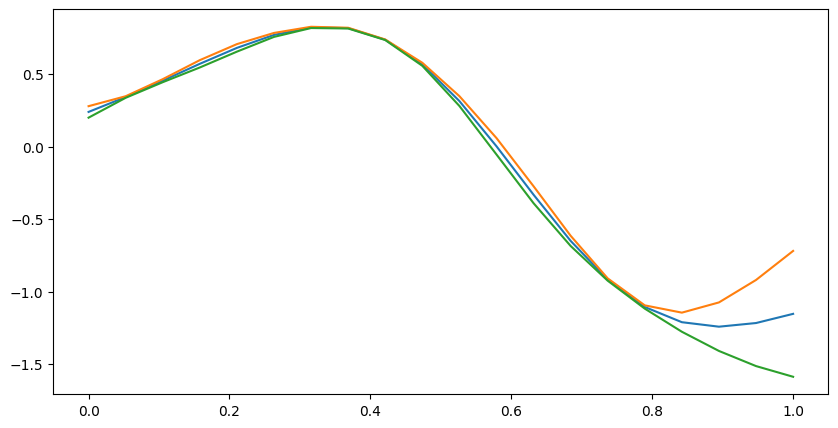

In [302]:
with torch.no_grad():
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    
    mean_ls = []
    upper_ls = []
    lower_ls = []
    
    for i in range(f_mean.shape[0]):
      mean = f_mean[i]
      mean_ls.append(mean)
      var = f_covar[i, i]
      assert var == f_var[i]
      upper_ls.append(mean + var)
      lower_ls.append(mean - var)
    
    plt.plot(test_X, mean_ls)
    plt.plot(test_X, upper_ls)
    plt.plot(test_X, lower_ls)

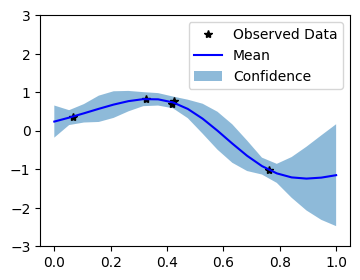

In [303]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    test_X = test_X.squeeze(-1)
    # Get upper and lower confidence bounds
    lower, upper = y_preds.confidence_region()
    # Plot training data as black stars
    ax.plot(train_X.numpy(), train_Y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_X.numpy(), y_preds.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [304]:
for name, value in likelihood.state_dict().items():
    print(name, value)

noise_covar.raw_noise tensor([-5.5612])
noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04)
noise_covar.raw_noise_constraint.upper_bound tensor(inf)
